In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import os
import joblib

pd.set_option("display.max_columns", 50)

In [2]:
DATA_PATH = "../data/raw/survey_results_public.csv"

df = pd.read_csv(DATA_PATH)
print(df.shape)

(49191, 172)


C:\Users\witch\AppData\Local\Temp\ipykernel_34476\2350051872.py:3: DtypeWarning: Columns (56,74,92,97,98,105,109,110,132,162,165) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


In [3]:
df.head()

,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,AILearnHow,YearsCode,DevType,OrgSize,ICorPM,RemoteWork,PurchaseInfluence,TechEndorseIntro,TechEndorse_1,TechEndorse_2,TechEndorse_3,TechEndorse_4,TechEndorse_5,TechEndorse_6,TechEndorse_7,...,AIAgentChange,AIAgent_Uses,AgentUsesGeneral,AIAgentImpactSomewhat agree,AIAgentImpactNeutral,AIAgentImpactSomewhat disagree,AIAgentImpactStrongly agree,AIAgentImpactStrongly disagree,AIAgentChallengesNeutral,AIAgentChallengesSomewhat disagree,AIAgentChallengesStrongly agree,AIAgentChallengesSomewhat agree,AIAgentChallengesStrongly disagree,AIAgentKnowledge,AIAgentKnowWrite,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,14.0,"Developer, mobile",20 to 99 employees,People manager,Remote,"Yes, I influenced the purchase of a substantia...",Work,10.0,7.0,9.0,6.0,3.0,11.0,12.0,...,Not at all or minimally,Software engineering,NaN,AI agents have increased my productivity.;AI a...,AI agents have helped me automate repetitive t...,NaN,NaN,NaN,I am concerned about the accuracy of the infor...,Integrating AI agents with my existing tools a...,The cost of using certain AI agent platforms i...,NaN,NaN,NaN,NaN,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,10.0,"Developer, back-end",500 to 999 employees,Individual contributor,"Hybrid (some in-person, leans heavy to flexibi...",No,Personal Project,13.0,1.0,2.0,9.0,4.0,3.0,12.0,...,Not at all or minimally,NaN,NaN,NaN,NaN,NaN,NaN,NaN,It takes significant time and effort to learn ...,NaN,I am concerned about the accuracy of the infor...,Integrating AI agents with my existing tools a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps;Technical ...,12.0,"Developer, front-end",NaN,NaN,NaN,No,Work,12.0,2.0,3.0,7.0,5.0,10.0,13.0,...,"Yes, somewhat",Software engineering,Multi-platform search enablement,AI agents have increased my productivity.;AI a...,AI agents have improved the quality of my code...,AI agents have improved collaboration within m...,NaN,NaN,It takes significant time and effort to learn ...,My company's IT and/or InfoSec teams have stri...,NaN,I am concerned about the accuracy of the infor...,NaN,Redis,NaN,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061.0,8.0
3,4,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,None of the above,4.0,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps;Videos (no...,5.0,"Developer, back-end","10,000 or mor

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49191 entries, 0 to 49190
Columns: 172 entries, ResponseId to JobSat
dtypes: float64(52), int64(1), object(119)
memory usage: 64.6+ MB


In [5]:
columns = [
    "ConvertedCompYearly",
    "YearsCode",
    "Country",
    "DevType",
    "LanguageHaveWorkedWith",
    "EdLevel"
]

df = df[columns]
df.head()

,ConvertedCompYearly,YearsCode,Country,DevType,LanguageHaveWorkedWith,EdLevel
0,61256.0,14.0,Ukraine,"Developer, mobile",Bash/Shell (all shells);Dart;SQL,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)"
1,104413.0,10.0,Netherlands,"Developer, back-end",Java,"Associate degree (A.A., A.S., etc.)"
2,53061.0,12.0,Ukraine,"Developer, front-end",Dart;HTML/CSS;JavaScript;TypeScript,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)"
3,36197.0,5.0,Ukraine,"Developer, back-end",Java;Kotlin;SQL,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)"
4,60000.0,22.0,Ukraine,Engineering manager,C;C#;C++;Delphi;HTML/CSS;Java;JavaScript;Lua;P...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)"


In [6]:
df = df.rename(columns={"ConvertedCompYearly": "salary"})

df = df[
    (df["salary"].notna()) &
    (df["salary"] > 5000) &
    (df["salary"] < 500_000)
]

print(df.shape)

(22015, 6)


In [7]:
df["YearsCode"] = pd.to_numeric(
    df["YearsCode"], errors="coerce"
)

df = df[df["YearsCode"].notna()]

print(df.shape)

(21942, 6)


In [8]:
def first_item(x):
    if pd.isna(x):
        return np.nan
    return x.split(";")[0]

df["PrimaryLanguage"] = df["LanguageHaveWorkedWith"].apply(first_item)
df["PrimaryRole"] = df["DevType"].apply(first_item)

df = df.drop(columns=["LanguageHaveWorkedWith", "DevType"])
df.head()

,salary,YearsCode,Country,EdLevel,PrimaryLanguage,PrimaryRole
0,61256.0,14.0,Ukraine,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Bash/Shell (all shells),"Developer, mobile"
1,104413.0,10.0,Netherlands,"Associate degree (A.A., A.S., etc.)",Java,"Developer, back-end"
2,53061.0,12.0,Ukraine,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Dart,"Developer, front-end"
3,36197.0,5.0,Ukraine,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Java,"Developer, back-end"
4,60000.0,22.0,Ukraine,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",C,Engineering manager


In [9]:
df.dropna()
print(df.shape)

(21942, 6)


In [10]:
df.to_csv("../data/processed/survey_results_salary_prediction.csv")

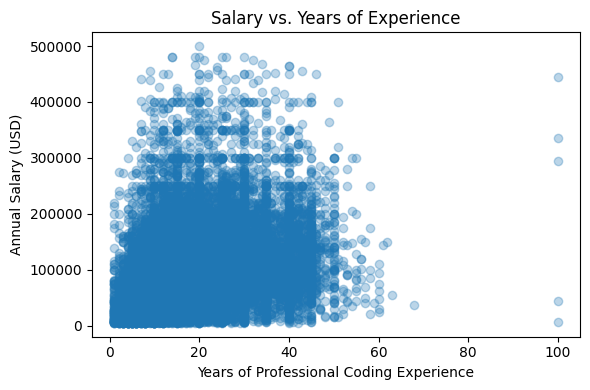

In [11]:
#Explore the effect of Coding experience on the Salary

plt.figure(figsize=(6, 4))
plt.scatter(df["YearsCode"], df["salary"], alpha=0.3)
plt.xlabel("Years of Professional Coding Experience")
plt.ylabel("Annual Salary (USD)")
plt.title("Salary vs. Years of Experience")

plt.tight_layout()
plt.savefig("../reports/figures/salary_vs_experience.png", dpi=150)
plt.show()

<Figure size 600x200 with 0 Axes>

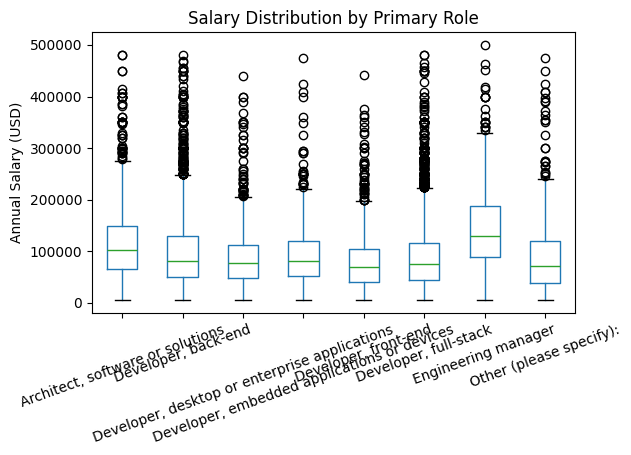

In [12]:
#Salary distribution by roles

top_roles = (
    df["PrimaryRole"]
    .value_counts()
    .head(8)
    .index
)

role_subset = df[df["PrimaryRole"].isin(top_roles)]

plt.figure(figsize=(6, 2))
role_subset.boxplot(
    column="salary",
    by="PrimaryRole",
    rot=20,
    grid=False
)

plt.title("Salary Distribution by Primary Role")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("")

plt.tight_layout()
plt.savefig("../reports/figures/salary_by_role.png", dpi=150)
plt.show()

<Figure size 600x200 with 0 Axes>

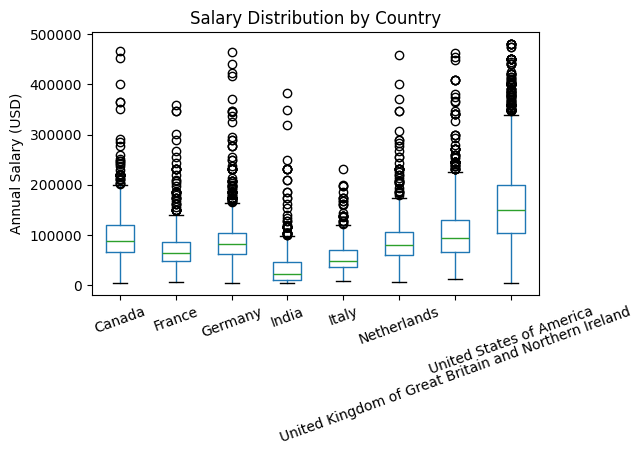

In [13]:
#Salary distribution by country

top_countries = (
    df["Country"]
    .value_counts()
    .head(8)
    .index
)

country_subset = df[df["Country"].isin(top_countries)]

plt.figure(figsize=(6, 2))
country_subset.boxplot(
    column="salary",
    by="Country",
    rot=20,
    grid=False
)

plt.title("Salary Distribution by Country")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("")

plt.tight_layout()
plt.savefig("../reports/figures/salary_by_country.png", dpi=150)
plt.show()

<Figure size 600x200 with 0 Axes>

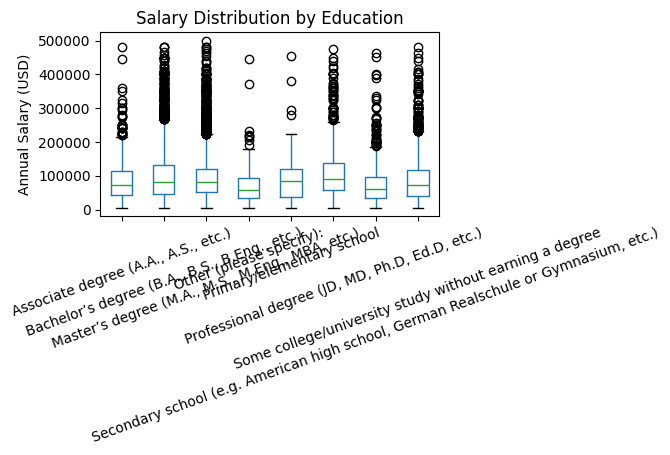

In [14]:
#Salary distribution by education

top_edu = (
    df["EdLevel"]
    .value_counts()
    .head(8)
    .index
)

edu_subset = df[df["EdLevel"].isin(top_edu)]

plt.figure(figsize=(6, 2))
edu_subset.boxplot(
    column="salary",
    by="EdLevel",
    rot=20,
    grid=False
)

plt.title("Salary Distribution by Education")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("")

plt.tight_layout()
plt.savefig("../reports/figures/salary_by_education.png", dpi=150)
plt.show()

<Figure size 600x200 with 0 Axes>

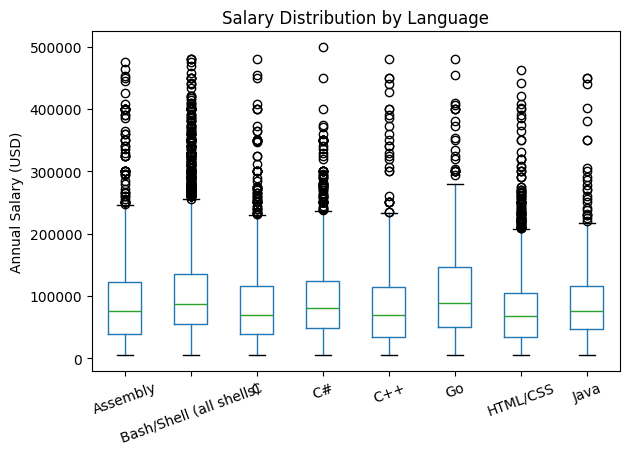

In [15]:
#Salary distribution by language

top_edu = (
    df["PrimaryLanguage"]
    .value_counts()
    .head(8)
    .index
)

edu_subset = df[df["PrimaryLanguage"].isin(top_edu)]

plt.figure(figsize=(6, 2))
edu_subset.boxplot(
    column="salary",
    by="PrimaryLanguage",
    rot=20,
    grid=False
)

plt.title("Salary Distribution by Language")
plt.suptitle("")
plt.ylabel("Annual Salary (USD)")
plt.xlabel("")

plt.tight_layout()
plt.savefig("../reports/figures/salary_by_language.png", dpi=150)
plt.show()

In [16]:
X = df.drop(columns="salary")
y = df["salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
categorical_features = [
    "Country",
    "PrimaryRole",
    "PrimaryLanguage",
    "EdLevel"
]

numeric_features = ["YearsCode"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

In [18]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

In [19]:
pipeline = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", model)
    ]
)

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Country', 'PrimaryRole',
                                                   'PrimaryLanguage',
                                                   'EdLevel']),
                                                 ('num', 'passthrough',
                                                  ['YearsCode'])])),
                ('model',
                 RandomForestRegressor(max_depth=12, n_jobs=-1,
                                       random_state=42))])

In [21]:
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "salary_rf_pipeline.joblib")
joblib.dump(pipeline, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to ../models\salary_rf_pipeline.joblib


In [22]:
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: ${mae:,.0f}")
print(f"R²: {r2:.2f}")

MAE: $34,984
R²: 0.44


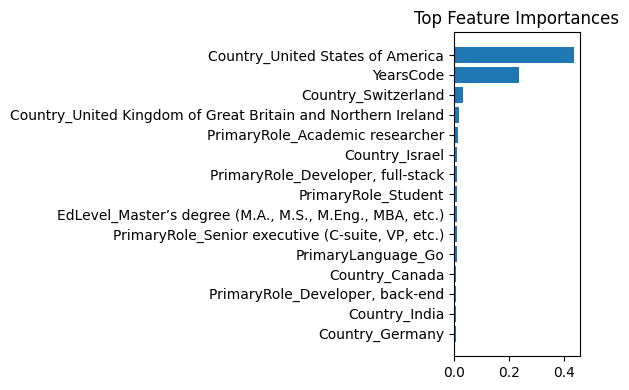

In [23]:
ohe = pipeline.named_steps["prep"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out()

feature_names = list(cat_features) + ["YearsCode"]

importances = pipeline.named_steps["model"].feature_importances_

fi = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(15)
)

plt.figure(figsize=(6, 4))
plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances")

plt.tight_layout()
plt.savefig("../reports/figures/feature_importance.png", dpi=150)
plt.show()

## Model Interpretation

This model is **not meant to be a production salary predictor**.

Key takeaways:
- Country of United States is the strongest factor
- Years of professional experience is the second strongest factor
- Other factors have marginal influence

Limitations:
- The data is self-reported and may not be accurate
- Model prediction power is limited (R²=0.44)
- Many factors are ignored to simplify the model for demo purpose